In [603]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

In [604]:
capital_data = pd.read_excel("capital spending data.xls")
gdp_data = pd.read_excel("gdp data.xls")
labor_data = pd.read_excel("labor force data.xls")
tfp_data = pd.read_excel("tfp data.xls")

In [605]:
# GDP data is currently quarterly. Turning it into annual data 

dates = gdp_data["observation_date"]
gdp_data.head()
annual_dates = [i for i in range(len(dates)) if dates.loc[i].month == 1]

annual_gdp_data = gdp_data.iloc[annual_dates]
annual_gdp_data.head()

,observation_date,GDP
0,1947-01-01,243.164
4,1948-01-01,265.742
8,1949-01-01,275.034
12,1950-01-01,280.828
16,1951-01-01,336.000


In [606]:
# capital spending 
capital_data.head()


,observation_date,capital
0,1946-10-01,53699.0
1,1947-01-01,NaN
2,1947-04-01,NaN
3,1947-07-01,NaN
4,1947-10-01,63265.0


In [607]:
# labor 
labor_annual_dates = [i for i in range(len(labor_data)) if labor_data.loc[i,"observation_date"].month == 1]
annual_labor_data = labor_data.iloc[labor_annual_dates]
annual_labor_data.head()

#sns.lineplot(data=annual_labor_data, x = "observation_date", y = "labor")

,observation_date,labor
0,1948-01-01,60095
12,1949-01-01,60771
24,1950-01-01,61661
36,1951-01-01,61941
48,1952-01-01,62432


In [608]:
# TFP 
tfp_data.head()


,observation_date,tfp
0,1954-01-01,0.650097
1,1955-01-01,0.671131
2,1956-01-01,0.667314
3,1957-01-01,0.674576
4,1958-01-01,0.675796


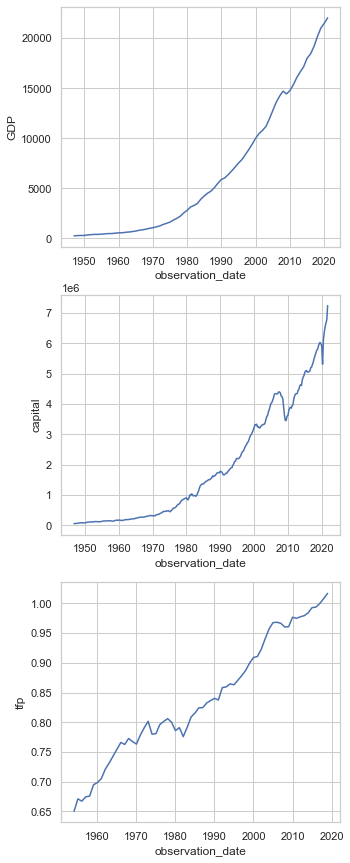

In [609]:
# join data into pandas Dataframe

df = pd.concat(
    [gdp_data["observation_date"],  labor_data["labor"],   capital_data["capital"],    tfp_data["tfp"],   gdp_data["GDP"]],
    axis = 1
)

# removing null values (sometimes capital or labor isn't found)
df = df.dropna()

# view all the parameters of gdp
fig, axs = plt.subplots(3,1, figsize=(5,15))
gdp_plot = sns.lineplot(data=annual_gdp_data, x = "observation_date", y ="GDP", ax=axs[0]) 
capital_plot = sns.lineplot(data = capital_data, x = "observation_date", y = "capital", ax=axs[1])
tfp_plot = sns.lineplot(data=tfp_data,x="observation_date",y="tfp", ax=axs[2])



In [610]:

def cobb_predict(row_index):
      labor = df.iloc[row_index,1]
      capital = df.iloc[row_index,2]
      tfp = df.iloc[row_index,3]
      
      # capital's share of income has been relatively constant at around 30% 
      return tfp * (capital)**0.3 * (labor)**0.7

cobb_predictions = [cobb_predict(i) for i in np.arange(len(df))]
df["cobb predictions"] = cobb_predictions
df.head()


,observation_date,labor,capital,tfp,GDP,cobb predictions
0,1947-01-01,60095,53699.0,0.650097,243.164,37770.671690
4,1948-01-01,59972,63265.0,0.675796,265.742,41184.031299
8,1949-01-01,60815,81774.0,0.720872,275.034,47912.629144
12,1950-01-01,60771,75590.0,0.766093,280.828,49705.918752
16,1951-01-01,61259,98677.0,0.763372,336.000,53953.505932


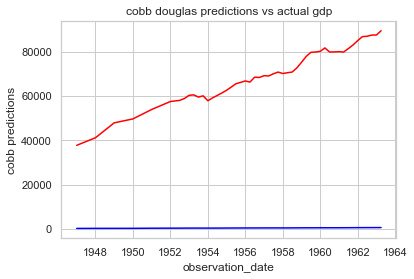

In [621]:

sns.set(style="whitegrid")
sns_plot = sns.lineplot(data=df, x="observation_date",y="cobb predictions", color = "red") 
sns_plot = sns.lineplot(data=df, x="observation_date",y="GDP", color = "blue").set(title="cobb douglas predictions vs actual gdp")

# the cobb douglas function we used doesn't do a good job predicting the GDP so lets adjust it


In [612]:
X = np.column_stack((np.ones(len(cobb_predictions)),cobb_predictions))
X
B = np.linalg.inv(X.T @ X) @ X.T @ df["GDP"]
B

def modified_cobb_predict(row_index):
      labor = df.iloc[row_index,1]/150
      capital = df.iloc[row_index,2]/150
      tfp = df.iloc[row_index,3]
      
      # capital's share of income has been relatively constant at around 30% 
      return tfp * (capital)**0.3 * (labor)**0.7

modified_cobb_predictions = [modified_cobb_predict(i) for i in np.arange(len(df))]

df["modified cobb predictions"] = modified_cobb_predictions
modified_cobb_MSE = mean_squared_error(df["GDP"], df["modified cobb predictions"])
print(f"predictions using the modified cobb douglas function: {modified_cobb_MSE}")

df.head()


predictions using the modified cobb douglas function: 324.5526544961534


,observation_date,labor,capital,tfp,GDP,cobb predictions,modified cobb predictions
0,1947-01-01,60095,53699.0,0.650097,243.164,37770.671690,251.804478
4,1948-01-01,59972,63265.0,0.675796,265.742,41184.031299,274.560209
8,1949-01-01,60815,81774.0,0.720872,275.034,47912.629144,319.417528
12,1950-01-01,60771,75590.0,0.766093,280.828,49705.918752,331.372792
16,1951-01-01,61259,98677.0,0.763372,336.000,53953.505932,359.690040


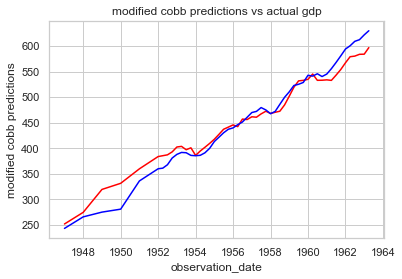

In [619]:
sns.set(style="whitegrid")
sns_plot = sns.lineplot(data=df, x="observation_date",y="modified cobb predictions", color = "red") 
sns_plot = sns.lineplot(data=df, x="observation_date",y="GDP", color = "blue").set(title="modified cobb predictions vs actual gdp")

# after using linear regression to fit the very poorly predicted cobb douglas gdp to the actual gdp our predicts are much closer 

,observation_date,labor,capital,tfp,GDP,cobb predictions,modified cobb predictions,regression predictions
0,1947-01-01,60095,53699.0,0.650097,243.164,37770.671690,251.804478,209.513218
4,1948-01-01,59972,63265.0,0.675796,265.742,41184.031299,274.560209,235.704600
8,1949-01-01,60815,81774.0,0.720872,275.034,47912.629144,319.417528,291.584015
12,1950-01-01,60771,75590.0,0.766093,280.828,49705.918752,331.372792,309.999447
16,1951-01-01,61259,98677.0,0.763372,336.000,53953.505932,359.690040,341.007938


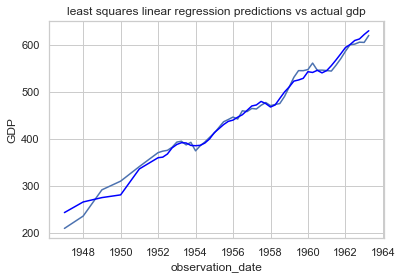

In [620]:
# using linear regression from the start 

X = np.column_stack((
    np.ones(len(cobb_predictions)),
    df["capital"],
    df["labor"],
    df["tfp"]
))

B = np.linalg.inv(X.T @ X) @ X.T @ df["GDP"]
B

def linear_regression(index):
    prediction = B[0] + B[1] * df.iloc[index]["capital"] + B[2] * df.iloc[index]["labor"] + B[3] * df.iloc[index]["tfp"]
    return prediction

regression_predictions = [linear_regression(i) for i in range(len(df))]
regression_predictions

sns.lineplot(x=df["observation_date"], y= regression_predictions)
sns.lineplot(data=df, x="observation_date",y="GDP", color = "blue").set(title="least squares linear regression predictions vs actual gdp")

df["regression predictions"] = regression_predictions
df.head()

In [615]:
cobb_MSE = mean_squared_error(df["GDP"], df["cobb predictions"])
modified_cobb_MSE = mean_squared_error(df["GDP"], df["modified cobb predictions"])
regression_MSE = mean_squared_error(df["GDP"], df["regression predictions"])

print(f"predictions using the cobb douglas function: {cobb_MSE}")
print(f"predictions using the modified cobb douglas function (labor and capital scaled by 150): {modified_cobb_MSE}")
print(f"predictions using linear regression: {regression_MSE}")


predictions using the cobb douglas function: 4838036787.745895
predictions using the modified cobb douglas function (labor and capital scaled by 150): 324.5526544961534
predictions using linear regression: 126.29048247552423


<font size="4"> CONCLUSION:<br>Using the annual raw labor and capital measurements found found from data.gov the cobb douglas function is extremely inaccurate. However, by scaling both labor and capital down by 150 the cobb douglas function is much more accurate. Nevertheless, traditional least squares linear regression was most accurate.</font>